# **Import the dataset and SMOTE**

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.activations import elu
from keras import backend as K
import pandas as pd
from imblearn.over_sampling import SMOTE 
from sklearn.metrics import confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
import eli5
from eli5.sklearn import PermutationImportance
from eli5 import show_weights, show_prediction

In [4]:
dataset = pd.read_csv('../../dataset/blood_dataset.csv').iloc[:, 2:]
data1, data2 =  train_test_split(dataset, test_size=0.4, random_state=42)
train1, test1  = train_test_split(data1, test_size=0.2, random_state=46)
train2, test2  = train_test_split(data2, test_size=0.2, random_state=32)

In [5]:
train1_X = train1.iloc[:,:-1]
train1_y = train1.iloc[:,-1]
test1_X = test1.iloc[:,:-1]
test1_y = test1.iloc[:,-1]

In [6]:
train1_X.head()

,A1BG..1.,A1CF..29974.,A2M..2.,A2ML1..144568.,A3GALT2..127550.,A4GALT..53947.,A4GNT..51146.,AAAS..8086.,AACS..65985.,AADAC..13.,...,ZWILCH..55055.,ZWINT..11130.,ZXDA..7789.,ZXDB..158586.,ZXDC..79364.,ZYG11A..440590.,ZYG11B..79699.,ZYX..7791.,ZZEF1..23140.,ZZZ3..26009.
650,0.147080,0.445694,0.017483,0.007169,0.045457,0.014632,0.067986,0.403468,0.035305,0.042075,...,0.123353,0.942294,0.054111,0.003993,0.023763,0.006771,0.074534,0.030963,0.040735,0.273131
819,0.041403,0.044806,0.015059,0.017849,0.014064,0.072826,0.114187,0.050226,0.030321,0.013896,...,0.833055,0.716253,0.012140,0.015239,0.019902,0.045649,0.077900,0.049628,0.058832,0.250032
704,0.010526,0.014056,0.043156,0.031235,0.018561,0.056506,0.022698,0.173124,0.020605,0.015097,...,0.010972,0.787811,0.073192,0.029455,0.077723,0.019042,0.092804,0.050415,0.481685,0.427200
898,0.021123,0.058064,0.021918,0.014077,0.175457,0.020636,0.015101,0.076689,0.224626,0.043011,...,0.657375,0.309251,0.018342,0.016745,0.041365,0.013402,0.059737,0.085355,0.077031,0.298912
389,0.037622,0.035071,0.052090,0.060095,0.084555,0.038729,0.086327,0.719724,0.044339,0.039472,...,0.153459,0.165303,0.011806,0.087887,0.019427,0.031437,0.047821,0.103173,0.265542,0.112986


# **Ensemble model of NN**

The idea is to fit $k + 1$ NNs models:

1. the first one will be the one trained on all lung obs and an equal number of non-lung obs randomly selected
2. ...
3. ...

And so forth up top the $k$-th model. 
We then define the prediction in voting fashion, possibly with a weight (i.e. a vote for lung could count more than a vote for non-lung).

As loss function we use the Focal Loss. Here’s the main idea: in our dataset, we will naturally have some training examples that are easier to classify than others (non-lung). During training, these examples will be classified with 99% accuracy, while other more challenging ones may still exhibit poor performance. The problem is that those easily classified training examples are still contributing to the loss. Why are we still giving them equal weight when there are other more challenging data points that if correctly classified can contribute much more to our overall accuracy?

$$FL(p_t) = \alpha \cdot (1-p_t)^\gamma \cdot \log{p_t}$$

Focal loss down-weights the well-classified examples. This has the net effect of putting more training emphasis on that data that is hard to classify! In a practical setting where we have a data imbalance, our majority class will quickly become well-classified since we have much more data for it. Thus, in order to insure that we also achieve high accuracy on our minority class, we can use the focal loss to give those minority class examples more relative weight during training. 

In [7]:
def binary_focal_loss(gamma=2., alpha=.25):
    """
    Binary form of focal loss.
      FL(p_t) = -alpha * (1 - p_t)**gamma * log(p_t)
      where p = sigmoid(x), p_t = p or 1 - p depending on if the label is 1 or 0, respectively.
    References:
        https://arxiv.org/pdf/1708.02002.pdf
    Usage:
     model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """

    def binary_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as y_pred
        :param y_pred:  A tensor resulting from a sigmoid
        :return: Output tensor.
        """
        y_true = tf.cast(y_true, tf.float32)
        # Define epsilon so that the back-propagation will not result in NaN for 0 divisor case
        epsilon = K.epsilon()
        # Add the epsilon to prediction value
        # y_pred = y_pred + epsilon
        # Clip the prediciton value
        y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
        # Calculate p_t
        p_t = tf.where(K.equal(y_true, 1), y_pred, 1 - y_pred)
        # Calculate alpha_t
        alpha_factor = K.ones_like(y_true) * alpha
        alpha_t = tf.where(K.equal(y_true, 1), alpha_factor, 1 - alpha_factor)
        # Calculate cross entropy
        cross_entropy = -K.log(p_t)
        weight = alpha_t * K.pow((1 - p_t), gamma)
        # Calculate focal loss
        loss = weight * cross_entropy
        # Sum the losses in mini_batch
        loss = K.mean(K.sum(loss, axis=1))
        return loss

    return binary_focal_loss_fixed

**$k$ undersampling NNs models**

In [8]:
models = []

metrics = [
        keras.metrics.FalseNegatives(name="fn"),
        keras.metrics.FalsePositives(name="fp"),
        keras.metrics.TrueNegatives(name="tn"),
        keras.metrics.TruePositives(name="tp"),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
    ]

for i in range(20):
    # create random undersampling of majority class
    rus = RandomUnderSampler(random_state=i)
    X_res, y_res = rus.fit_resample(train1_X, train1_y)


    model_i = keras.Sequential(
    [
        keras.layers.Dense(400, activation="relu", input_shape=(17393,)),
        keras.layers.Dense(300, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
    )


    model_i.compile(
        optimizer='adam', loss="binary_crossentropy", metrics=metrics
        )

    model_i.fit(X_res, y_res, batch_size=len(X_res), epochs=40, verbose=0)

    models.append(model_i)
        

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2021-12-04 09:44:25.282481: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-04 09:44:25.283466: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2021-12-04 09:44:26.472014: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-04 09:44:26.475543: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-12-04 09:44:26.857888: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 09:44:29.297424: I tensorflow/core/grappler/

**Confusion matrix on test**

In [9]:
sum_pred = 0
for i in range(len(models)):
    sum_pred += models[i].predict(test1_X)

ensemble_prediction = (sum_pred/len(models)) > 0.5
conf_matr = confusion_matrix(test1_y, ensemble_prediction)
conf_matr

2021-12-04 09:45:15.271993: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 09:45:15.355679: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 09:45:15.435737: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 09:45:15.521349: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 09:45:15.604916: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 09:45:15.695126: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 09:45:15.789010: I tensorflow/core/grappler/optimizers/cust

array([[109,   1],
       [  0,  13]])

# **Variable selection with permutation importance**

Feature importance techniques were developed to help assuage this interpretability crisis. Feature importance techniques assign a score to each predictor based on its ability to improve predictions. This allows us to rank the predictors in our model based on their relative predictive power.

The idea behind feature importance is simple. Inputs that are useful for prediction contain valuable information. If you destroy that information by randomly shuffling the feature values, the quality of your predictions should decrease. If the decrease in quality is small, then the information in the original predictor wasn’t very impactful in determining your predictions — your model is still pretty good without it. Furthermore, if the decrease is large, then the information in the original predictor had a large impact on your predictions.

This idea is implemented in three simple steps. Say that you’ve trained an ML model and recorded some measure of quality for the predictions (ex. MSE, log-loss, etc). For each predictor in the dataset:

1. Randomly shuffle the data in the predictor while keeping the values of other predictors constant

2. Generate new predictions based on the shuffled values and evaluate the quality of your new predictions

3. Compute the feature importance score by calculating the decrease in the quality of your new predictions relative to your original predictions

Once you’ve computed feature importance scores for all of your features, you can rank them in terms of predictive usefulness. To help explain permutation feature importance more concretely, consider the following synthetic case study.

In [16]:
def nn_model():
    model_i = keras.Sequential([
        keras.layers.Dense(400, activation="relu", input_shape=(17393,)),
        keras.layers.Dense(300, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation="sigmoid"),
    ])

    model_i.compile(optimizer='adam', loss="binary_crossentropy", metrics=['accuracy'])

    return model_i

In [17]:
sum_weight = 0

for i in range(1):

    # define the model
    rus = RandomUnderSampler(random_state=i)
    X_res, y_res = rus.fit_resample(train1_X, train1_y)

    my_model = KerasClassifier(build_fn=nn_model)    
    my_model.fit(X_res,y_res)

    perm = PermutationImportance(my_model, random_state=i).fit(test1_X, test1_y)
    sum_weight += perm.feature_importances_
    print("done: " + str(i))

avg_importance = pd.DataFrame(sorted(sum_weight/1, reverse=True))

1/4 [======>.......................] - ETA: 0s - loss: 0.6853 - accuracy: 0.5312

2021-12-04 09:46:48.495381: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 9ms/step - loss: 0.2841 - accuracy: 0.8943


2021-12-04 09:46:48.849091: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1/4 [======>.......................] - ETA: 0s - loss: 0.2291 - accuracy: 0.93

KeyboardInterrupt: 

In [ ]:
avg_importance[:120].plot.bar(figsize = (25, 10), color = 'r')
plt.title('NN Permutation Importance Importance (Top 120)')
plt.xlabel('Features')
plt.show()

# **Test permutation importance on iris dataset**

In [11]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

iris = load_iris()
X = iris['data']
y = iris['target']
names = iris['target_names']
feature_names = iris['feature_names']

# One hot encoding
enc = OneHotEncoder()
Y = enc.fit_transform(y[:, np.newaxis]).toarray()

# Scale data to have mean 0 and variance 1 
# which is importance for convergence of the neural network
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data set into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(
    X_scaled, Y, test_size=0.5, random_state=2)

n_features = X.shape[1]
n_classes = Y.shape[1]

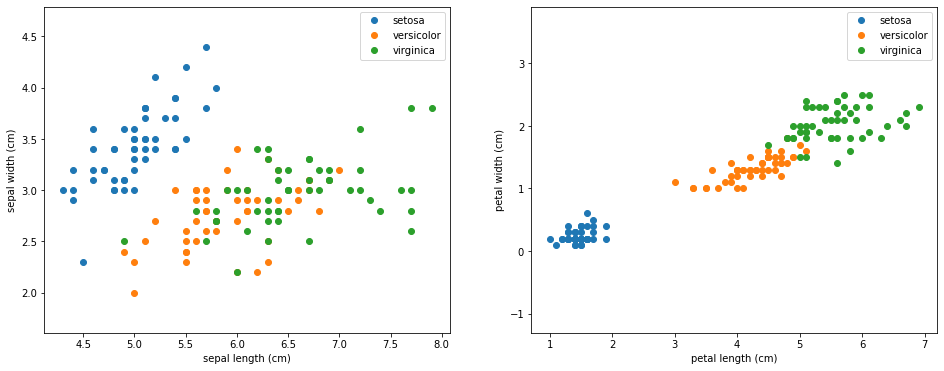

In [12]:
# Visualize the data sets
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
for target, target_name in enumerate(names):
    X_plot = X[y == target]
    plt.plot(X_plot[:, 0], X_plot[:, 1], linestyle='none', marker='o', label=target_name)
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.axis('equal')
plt.legend();

plt.subplot(1, 2, 2)
for target, target_name in enumerate(names):
    X_plot = X[y == target]
    plt.plot(X_plot[:, 2], X_plot[:, 3], linestyle='none', marker='o', label=target_name)
plt.xlabel(feature_names[2])
plt.ylabel(feature_names[3])
plt.axis('equal')
plt.legend();

In [13]:
sum_weight = 0

def nn_model():
    model_i = keras.Sequential([
        keras.layers.Dense(8, activation="relu", input_shape=(4,)),
        keras.layers.Dense(4, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(3, activation="softmax"),
    ])

    model_i.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])

    return model_i

for i in range(10):

    # define the model
    rus = RandomUnderSampler(random_state=i)
    X_res, y_res = rus.fit_resample(X_train, Y_train)

    my_model = KerasClassifier(build_fn=nn_model)    
    my_model.fit(X_res,y_res)

    perm = PermutationImportance(my_model, random_state=i).fit(X_test, Y_test)
    sum_weight += perm.feature_importances_

avg_importance = pd.DataFrame(sorted(sum_weight/10, reverse=True))

3/3 [==============================] - 0s 17ms/step - loss: 1.2059 - accuracy: 0.2609


2021-12-04 09:45:51.144090: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1/3 [=========>....................] - ETA: 0s - loss: 1.1655 - accuracy: 0.1875

2021-12-04 09:45:51.349629: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1/3 [=========>....................] - ETA: 0s - loss: 1.2816 - accuracy: 0.3438

2021-12-04 09:45:52.255140: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 09:45:52.401406: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1/3 [=========>....................] - ETA: 0s - loss: 1.3130 - accuracy: 0.1875

2021-12-04 09:45:53.313816: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 09:45:53.465046: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1/3 [=========>....................] - ETA: 0s - loss: 1.2381 - accuracy: 0.3125

2021-12-04 09:45:54.378248: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 09:45:54.527488: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1/3 [=========>....................] - ETA: 0s - loss: 0.6830 - accuracy: 0.7500

2021-12-04 09:45:55.447421: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 09:45:55.602045: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1/3 [=========>....................] - ETA: 0s - loss: 1.4620 - accuracy: 0.1250

2021-12-04 09:45:56.513264: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 09:45:56.666889: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1/3 [=========>....................] - ETA: 0s - loss: 1.0296 - accuracy: 0.4062

2021-12-04 09:45:57.577011: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 09:45:57.726606: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 20ms/step - loss: 1.1535 - accuracy: 0.3768


2021-12-04 09:45:58.656733: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 09:45:58.823728: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1/3 [=========>....................] - ETA: 0s - loss: 1.0116 - accuracy: 0.3438

2021-12-04 09:45:59.755775: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 09:45:59.908325: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 21ms/step - loss: 1.4133 - accuracy: 0.1304


2021-12-04 09:46:00.825034: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 09:46:00.990828: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 6ms/step - loss: 1.2421 - accuracy: 0.1600


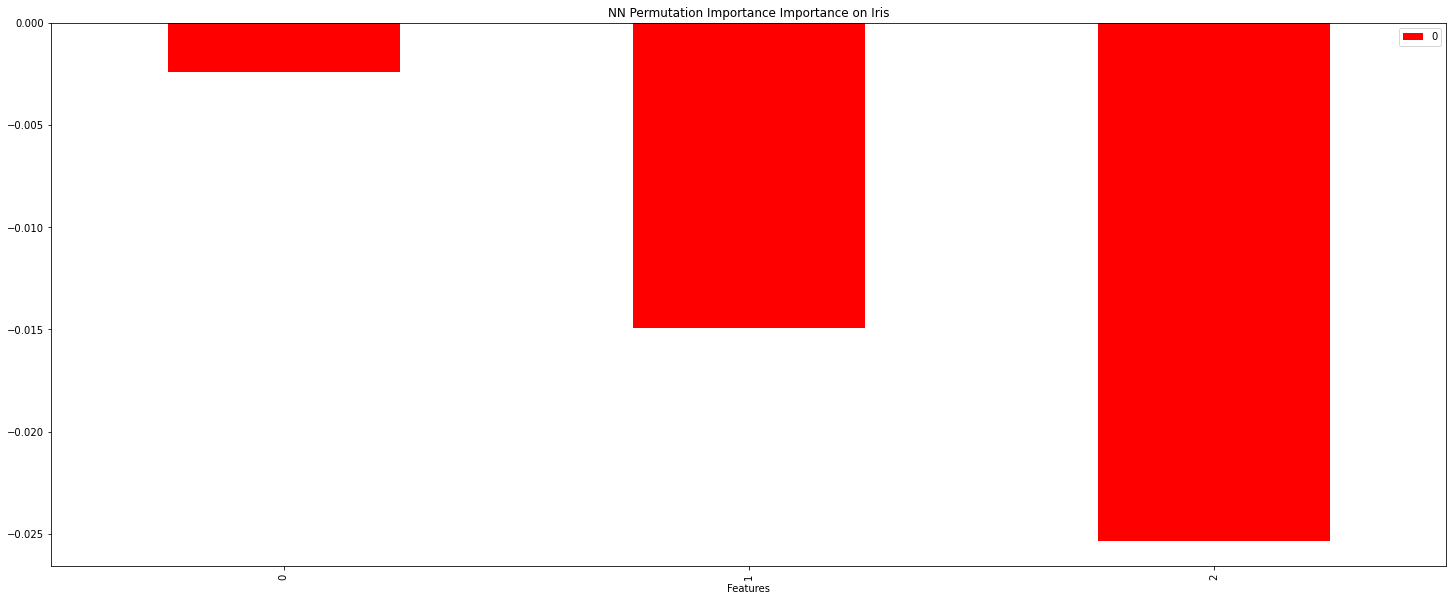

In [14]:
avg_importance[:3].plot.bar(figsize = (25, 10), color = 'r')
plt.title('NN Permutation Importance Importance on Iris')
plt.xlabel('Features')
plt.show()